In [2]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.9 MB/s eta 0:00:00


In [13]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras
from itertools import chain
# import matplotlib.pyplot as plt
import cv2


import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model_2 = tf.keras.models.load_model("/content/drive/MyDrive/ChickMed/ML/yolo_v8_xs_backbone_coco (1).h5",
    custom_objects={
    "YOLOV8Detector": keras_cv.models.YOLOV8Detector,
    "YOLOV8Backbone": keras_cv.models.YOLOV8Backbone
            },
    compile = False)

1/1 [==============================] - 0s 146ms/step


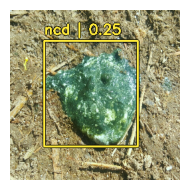

In [7]:
image = tf.io.read_file("/content/drive/MyDrive/ChickMed/ML/20160320_135433.jpg")
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image,(256,256))
image = tf.expand_dims(image,axis = 0)
predictions = model_2.predict(image)
y_pred = bounding_box.to_ragged(predictions)
visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        bounding_box_format="xywh",
        y_pred=y_pred,
        scale=2,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [14]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ChickMed/ML/Model_YOLOv8/Best_Model_YOLOv8.h5",
    custom_objects={
    "YOLOV8Detector": keras_cv.models.YOLOV8Detector,
    "YOLOV8Backbone": keras_cv.models.YOLOV8Backbone
            },
    compile = False)

In [15]:
class_ids = [
    "salmo",
    'cocci',
    'healthy',
    'ncd',
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'salmo', 1: 'cocci', 2: 'healthy', 3: 'ncd'}

1/1 [==============================] - 6s 6s/step


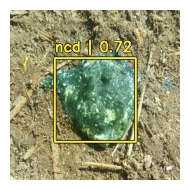

In [16]:
image = tf.io.read_file("/content/drive/MyDrive/ChickMed/ML/20160320_135433.jpg")
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image,(256,256))
image = tf.expand_dims(image,axis = 0)
predictions = model.predict(image)
y_pred = bounding_box.to_ragged(predictions)
visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        bounding_box_format="xywh",
        y_pred=y_pred,
        scale=2,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

In [11]:
open("yolov8_model.tflite", "wb").write(tflite_model)

14169152

In [ ]:
model_2 = tf.keras.models.load_model("/content/drive/MyDrive/ChickMed/ML/model.h5",
    custom_objects={
    "YOLOV8Detector": keras_cv.models.YOLOV8Detector,
    "YOLOV8Backbone": keras_cv.models.YOLOV8Backbone
            },
    compile = False)

1/1 [==============================] - 5s 5s/step


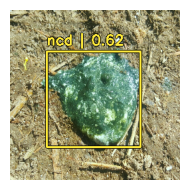

In [ ]:
image = tf.io.read_file("/content/drive/MyDrive/ChickMed/ML/20160320_135433.jpg")
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image,(256,256))
image = tf.expand_dims(image,axis = 0)
predictions = model_2.predict(image)
y_pred = bounding_box.to_ragged(predictions)
visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        bounding_box_format="xywh",
        y_pred=y_pred,
        scale=2,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [ ]:
def get_prediction(image_path,model):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image,(256,256))
    image = tf.expand_dims(image,axis = 0)
    predictions = model.predict(image)
    return predictions

In [ ]:
def draw_prediction(image_path,model):
    #compute class mapping
    class_ids = ["salmo",'cocci','healthy','ncd',]
    class_mapping = dict(zip(range(len(class_ids)), class_ids))
    color_list = [(231,76,60),(52,152,219),(39, 231, 96),(243,156,18)]
    #get original image
    original_image = cv2.imread(image_path)
    #original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    width = original_image.shape[1]
    height = original_image.shape[0]

    #get scaled image
    scale_width = width / 256
    scale_height = height / 256

    #get predictions
    predictions = get_prediction(image_path,model)

    #get boxes, confindences and classes
    num_detections = int(predictions['num_detections'][0])
    classes = predictions['classes'][0]
    confindences = predictions['confidence'][0]
    boxes = predictions['boxes'][0]


    for i in range(num_detections):
        class_id = int(classes[i])
        class_name = class_mapping[class_id]
        x,y,w,h = boxes[i]
        x1 = int(x * scale_width)
        y1 = int(y * scale_height)
        w = int(w * scale_width)
        h = int(h * scale_height)
        x2 = x1 + w
        y2 = y1 + h
        #check if box is out of bounds
        if x1 < 0:
            x1 = int(0 + width*0.05)
        if y1 < 0:
            y1 = int(0 + height*0.05)
        if x2 > width:
            x2 = int(width - width*0.05)
        if y2 > height:
            y2 = int(height - height*0.05)

        cv2.rectangle(original_image, (x1, y1), (x2, y2), color_list[class_id], 1)

        linewidth = min(int((x2-x1)*0.2),int((y2-y1)*0.2))
        cv2.line(original_image, (x1, y1), (x1+linewidth, y1), color_list[class_id], 4)
        cv2.line(original_image, (x1, y1), (x1, y1+linewidth), color_list[class_id], 4)
        cv2.line(original_image, (x2, y1), (x2-linewidth, y1), color_list[class_id], 4)
        cv2.line(original_image, (x2, y1), (x2, y1+linewidth), color_list[class_id], 4)

        cv2.line(original_image, (x1, y2), (x1+linewidth, y2), color_list[class_id], 4)
        cv2.line(original_image, (x1, y2), (x1, y2-linewidth), color_list[class_id], 4)
        cv2.line(original_image, (x2, y2), (x2-linewidth, y2), color_list[class_id], 4)
        cv2.line(original_image, (x2, y2), (x2, y2-linewidth), color_list[class_id], 4)





    #save image
    cv2.imwrite('prediction.jpg',original_image)
    return original_image

In [ ]:
path = "/content/drive/MyDrive/ChickMed/ML/20160320_135433.jpg"
image = draw_prediction(path,model)

1/1 [==============================] - 7s 7s/step
